In [26]:
import numpy as np
import matplotlib.pyplot as plt 

In [27]:
coor_array=[]

long_coord = []
lat_coord = []

for i in range(2):
    long_coord.append(180*i)
for k in range(7):
    lat_coord.append(-15*k)

for lat in lat_coord:
    for long in long_coord:
        
        coor_array.append((long,lat))

In [28]:
sample_data = np.asarray(np.genfromtxt('../GS4/GS4_Trace{}'.format(1), dtype=float,
                         delimiter="\t", autostrip=True,skip_header=1, names =True))
length=len(sample_data)
print(sample_data.shape)

(600,)


In [29]:
raw_data_array=np.empty([180,2,600])
for i in range(180):
    raw_data = np.genfromtxt('../GS4/GS4_Trace{}'.format(i), dtype=float,
    delimiter="\t", autostrip=True,skip_header=1, names =True)
    raw_x=np.array([pair[0] for pair in raw_data])
    raw_y=np.array([pair[1] for pair in raw_data])
    raw_data_array[i,0,:]=raw_x
    raw_data_array[i,1,:]=raw_y

print(np.mean(raw_data_array[0,:,:],axis=1))

# convert to micro-volt and MHz
raw_data_array[:,1,:]=1e6*raw_data_array[:,1,:]
raw_data_array[:,0,:]=raw_data_array[:,0,:]/1e6

print(np.mean(raw_data_array[0,:,:],axis=1))

[1.42040167e+09 1.77182407e-05]
[1420.40166667   17.71824068]


In [30]:
sample_vx=raw_data_array[0,0,:]
sample_vy=raw_data_array[0,1,:]

In [31]:
# check the data is what we want
binw = 0.000003333333
ntbin=(sample_vx[length-1]-sample_vx[0])/binw
ntbin=ntbin+1
print(ntbin)

599001.1599000507


# Finding proportionality constant from sun data

In [32]:
# Finding proportionality constant from sun data
sunAmp = 2.3133616383333307e-05
TSun = 100000
viewSRT = .016
viewSun = 6.8e-5
TempPropConstant = (sunAmp*viewSRT)/(TSun*viewSun)
P2T= TempPropConstant*1e9
print(P2T)

54.432038549019545


# Convert to velocity 

In [33]:
xx=raw_data_array[:,0,:]
vy=raw_data_array[:,1,:]

def get_velocity(frequency):
    return(3e5*(1-1420.4/frequency))
xv=get_velocity(xx)

In [34]:
def get_dBm(milvolt):
    volt=milvolt/1e6
    return(10.*np.log10(volt*volt*1000./50))

def get_power(milvolt):
    volt=milvolt/1e6
    return(1e12*volt*volt/50)

In [35]:
yV=vy
yD=get_dBm(vy)
yP=get_power(vy)

In [36]:
#set the errors
shape=xx.shape
xxerror=np.full(shape,0.0)
yVerror=np.full(shape,0.03)
yDerror=np.full(shape,0.03)
yPerror=np.full(shape,0.03)
yTerror=np.full(shape,2.0)

In [37]:
#delete sharp peaks
ymax=5.25
mult=1.10

start=3
end=length-3


def del_peak(yP_vector):
    yP=np.copy(yP_vector)
    for i in np.arange(start,end):
        ytmp=yP[i]
        ytmpM=yP[i-2]
        ytmpP=yP[i+2]
        yavg=(ytmpM+ytmpP)/2.0
        if ytmp < (mult*yavg):
            pass
        else:
            yP[i]=yavg
            yP[i-1]=yavg
            yP[i+1]=yavg
#     print(np.all(yP==yP_vector))
    return(yP)

In [38]:
def test_del_peak():
    for i in range(180):
        yP_vector=yP[i,:]
        diff=yP_vector-del_peak(yP_vector)
        if np.sum(diff)!=0:
            print("it's working")
            break
                
test_del_peak()

it's working


In [39]:
yP_no_peak=np.apply_along_axis(del_peak,1,yP)

In [86]:
xv[1,:][100:500]

array([-140.16676798, -139.46215504, -138.75754541, -138.05272768,
       -137.34812467, -136.64352496, -135.93871717, -135.23412408,
       -134.5295343 , -133.82473643, -133.12015326, -132.41557341,
       -131.71078547, -131.00621223, -130.3016423 , -129.59686429,
       -128.89230097, -128.18774097, -127.48297288, -126.7784195 ,
       -126.07386942, -125.36911126, -124.66456779, -123.96002764,
       -123.25527941, -122.55074587, -121.84621564, -121.14147733,
       -120.43695372, -119.73243341, -119.02770504, -118.32319135,
       -117.61868096, -116.91396251, -116.20945875, -115.50495829,
       -114.80024976, -114.09575592, -113.39126538, -112.68656679,
       -111.98208287, -111.27760225, -110.57291358, -109.86843959,
       -109.1639689 , -108.45929015, -107.75482608, -107.05036531,
       -106.34569649, -105.64124234, -104.9367915 , -104.2321326 ,
       -103.52768837, -102.82324745, -102.11859849, -101.41416418,
       -100.70973318, -100.00509414,  -99.30066975,  -98.59624

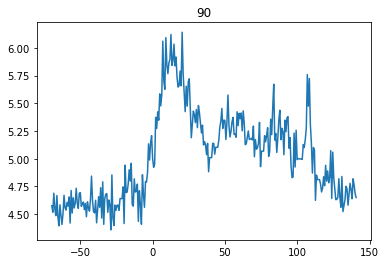

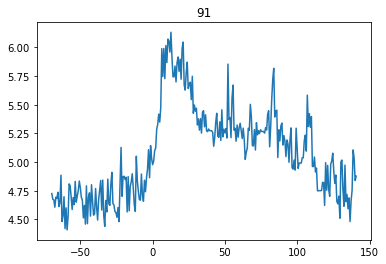

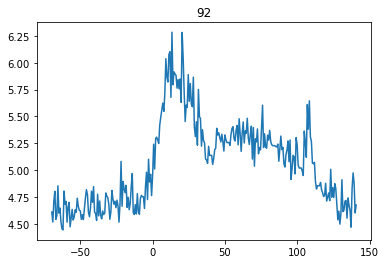

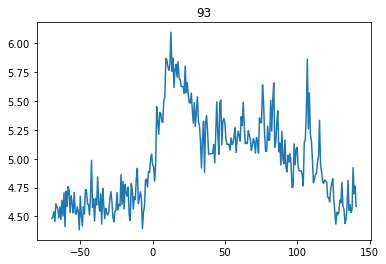

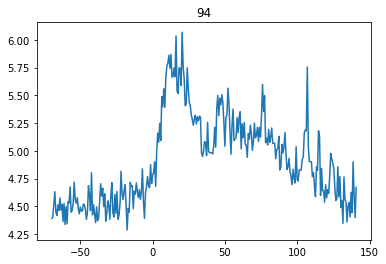

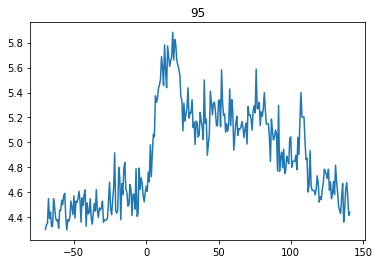

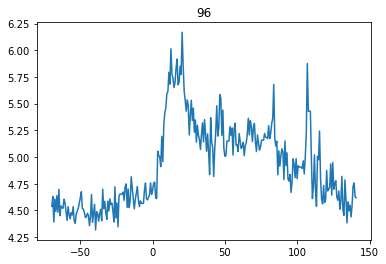

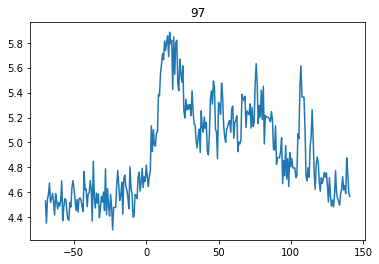

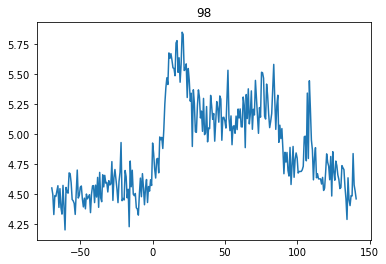

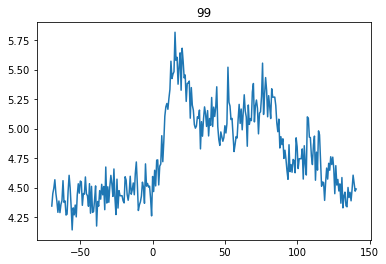

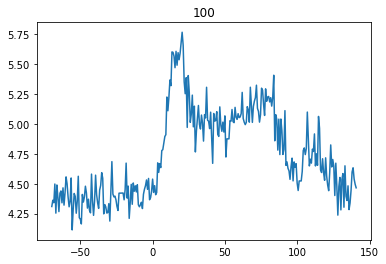

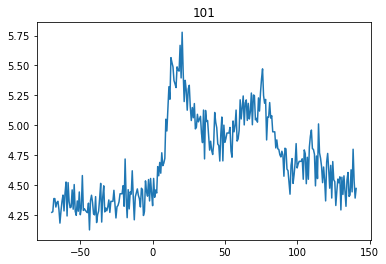

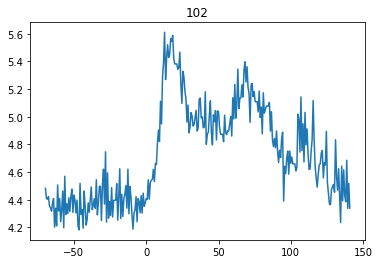

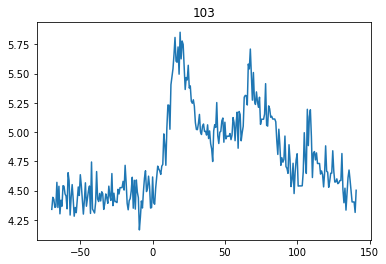

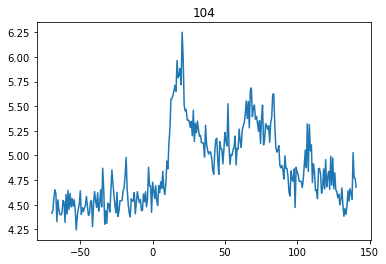

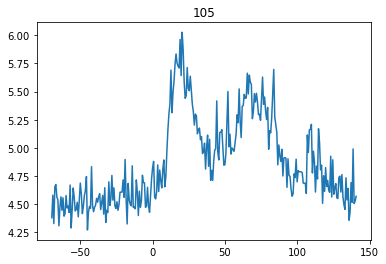

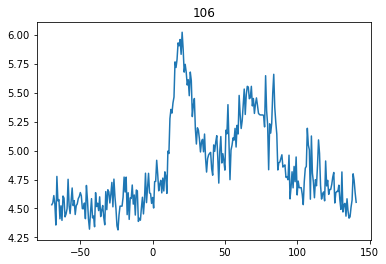

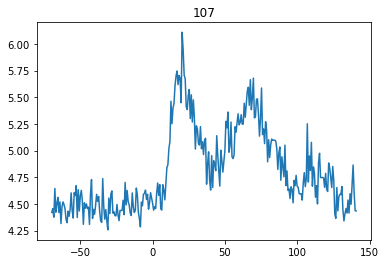

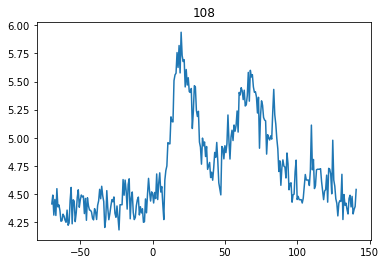

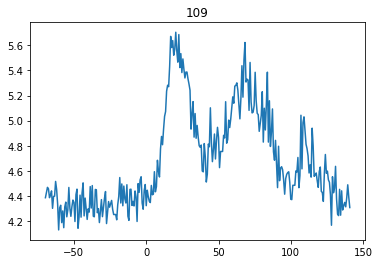

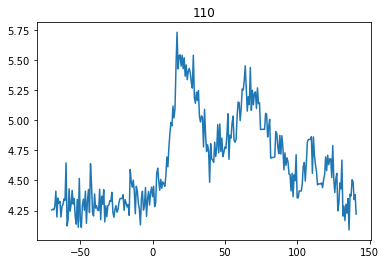

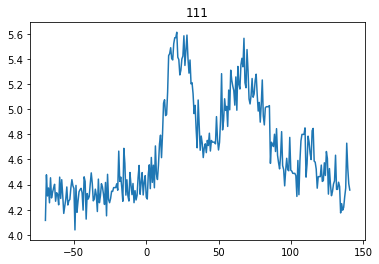

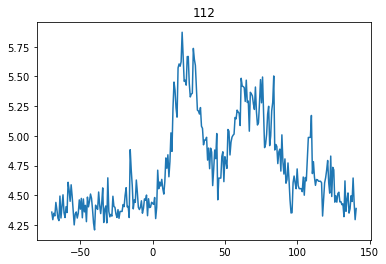

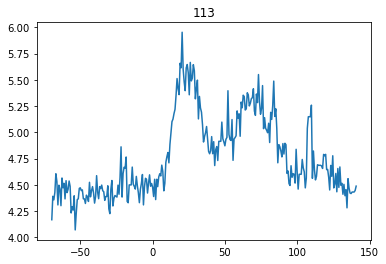

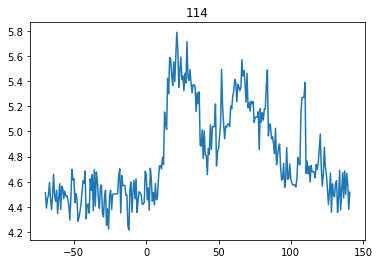

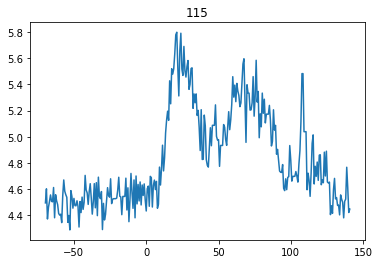

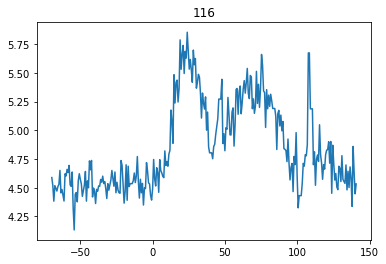

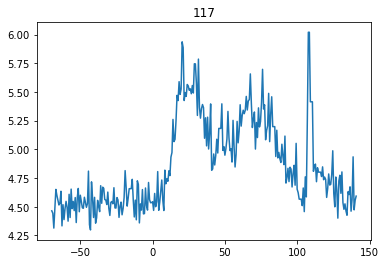

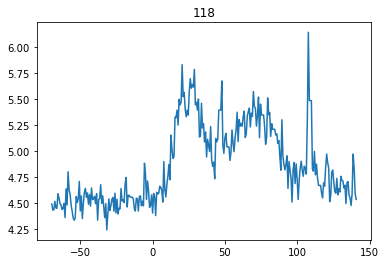

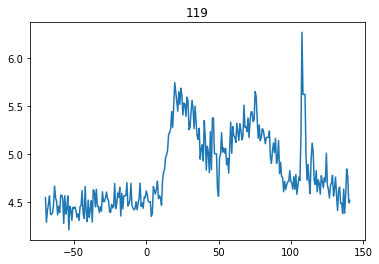

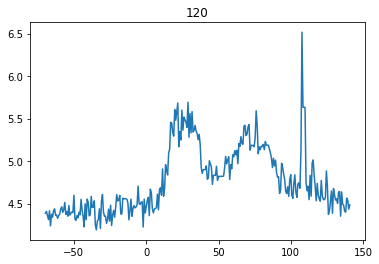

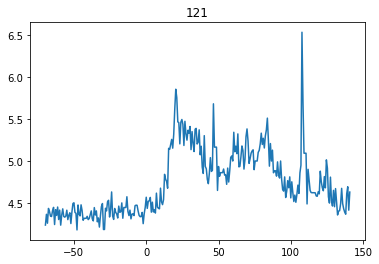

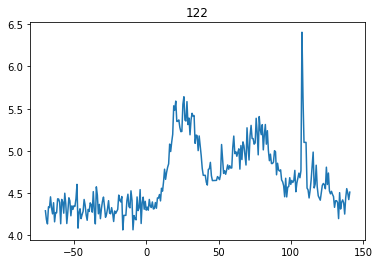

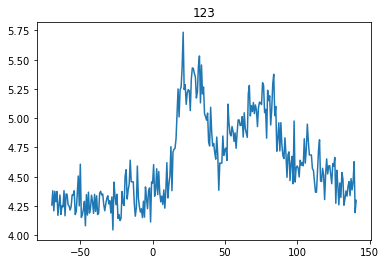

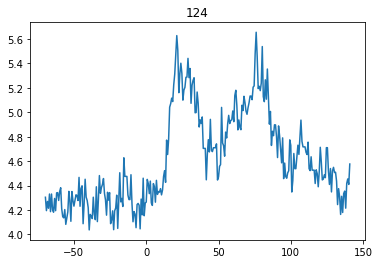

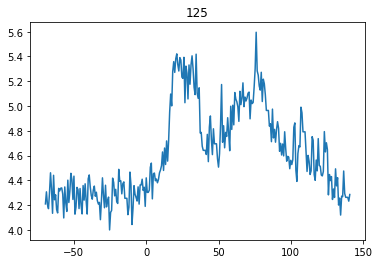

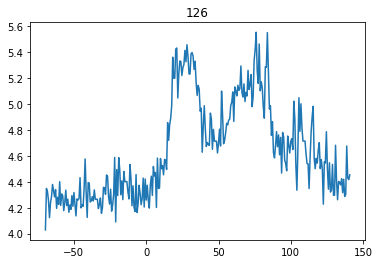

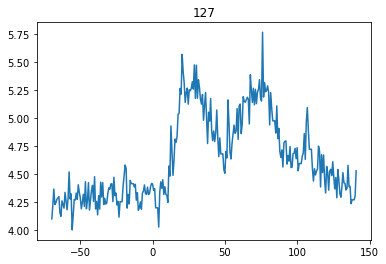

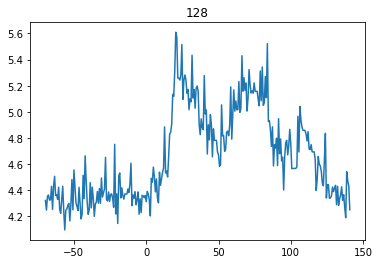

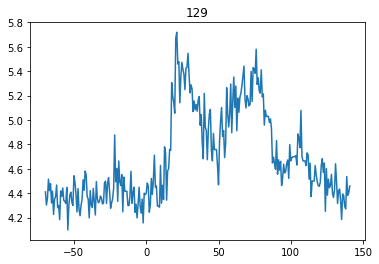

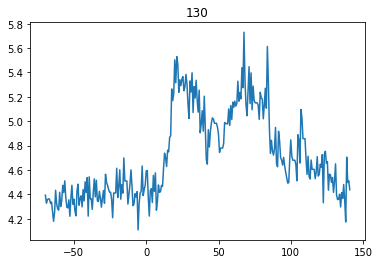

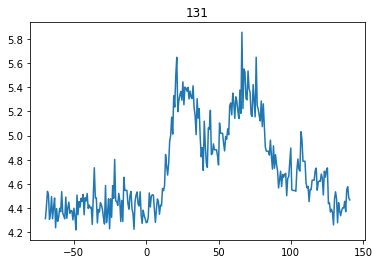

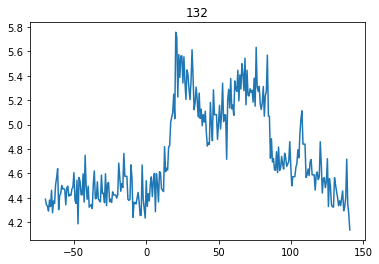

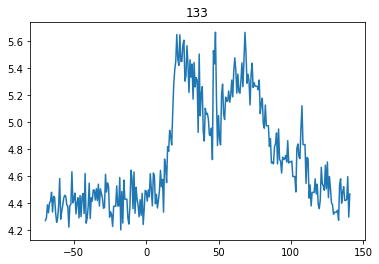

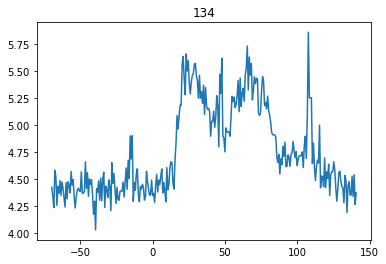

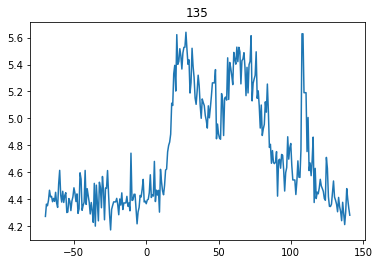

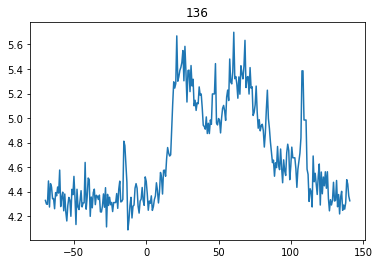

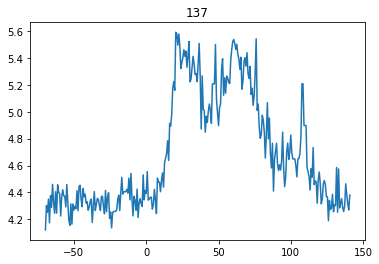

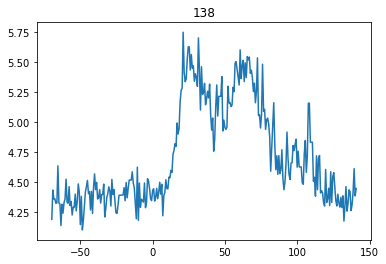

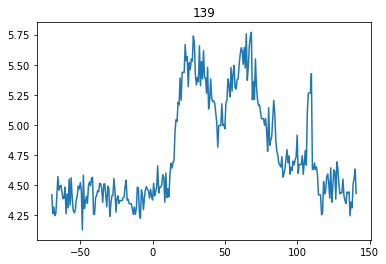

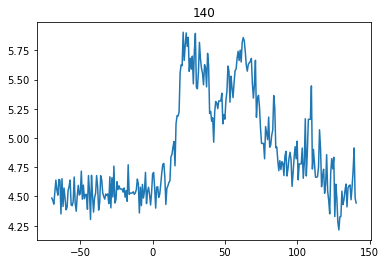

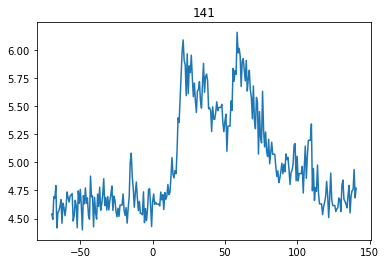

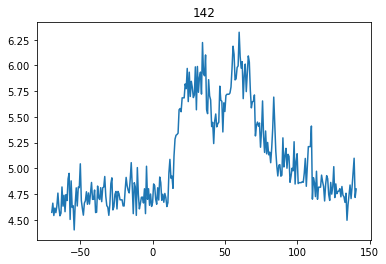

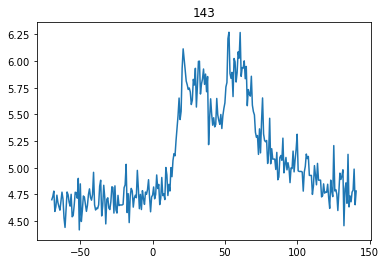

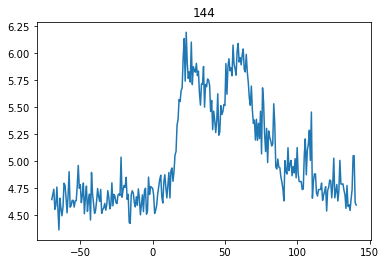

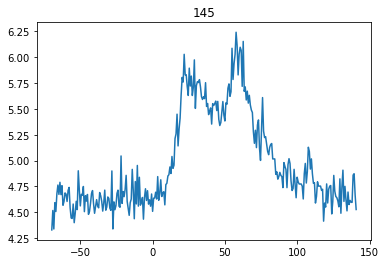

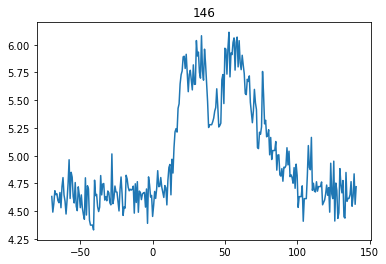

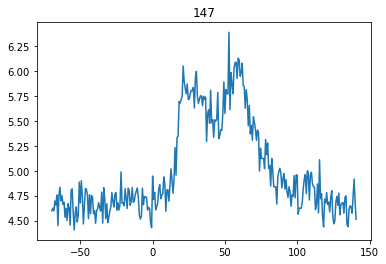

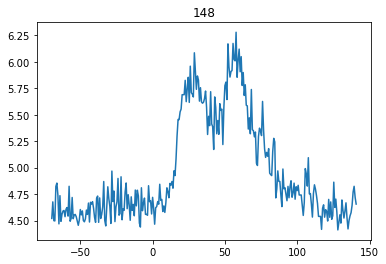

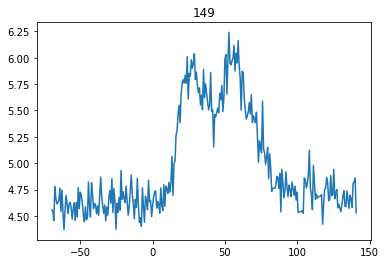

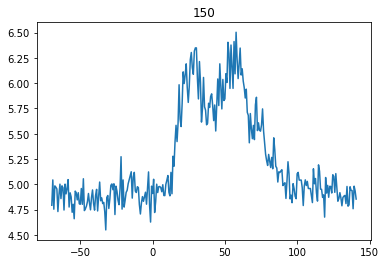

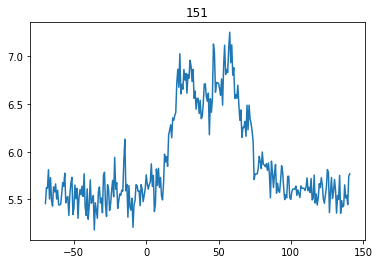

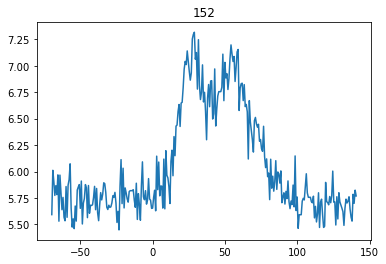

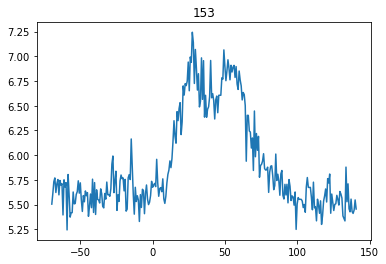

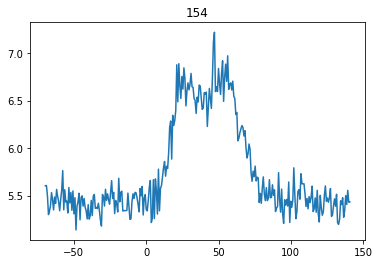

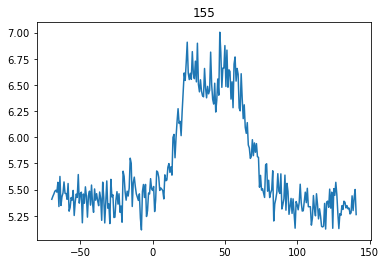

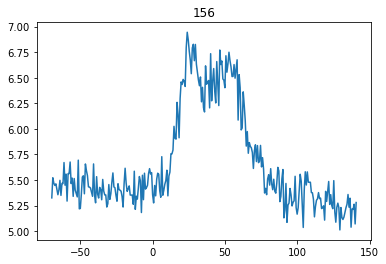

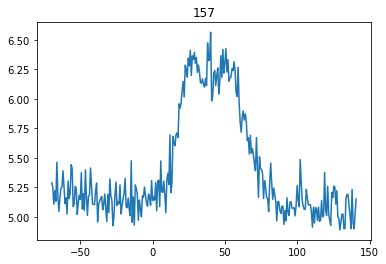

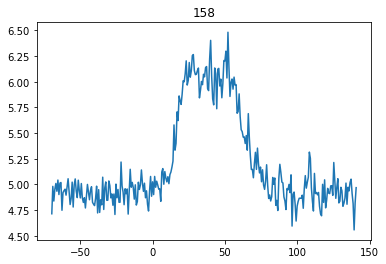

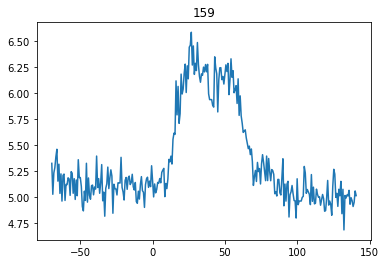

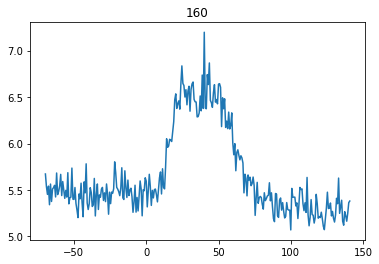

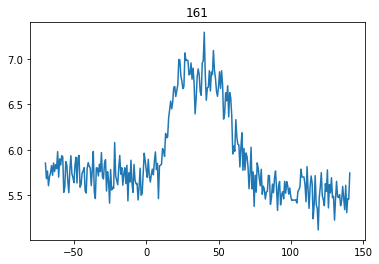

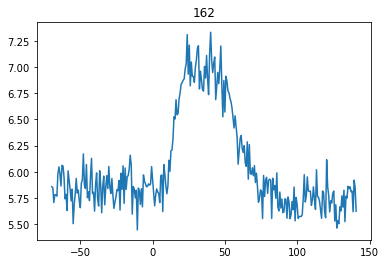

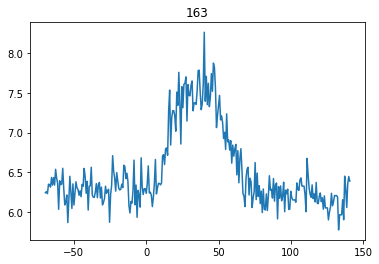

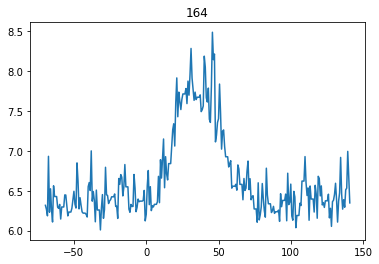

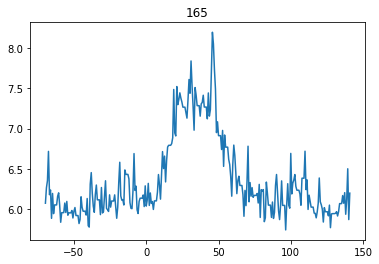

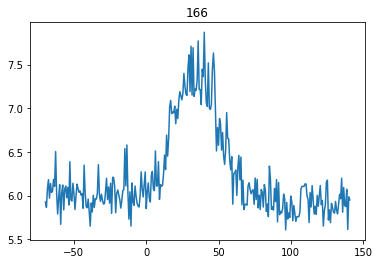

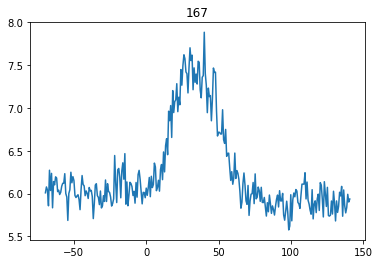

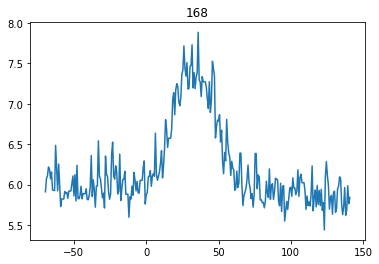

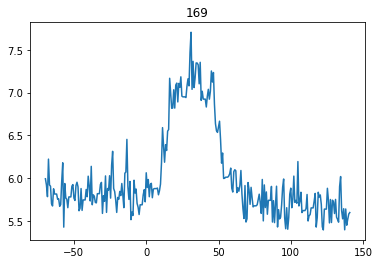

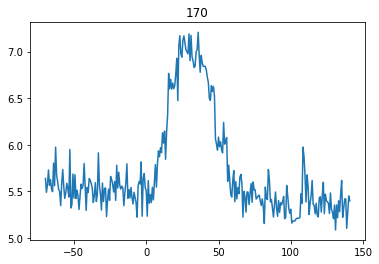

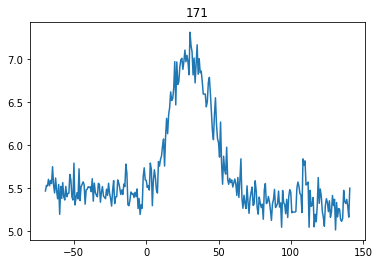

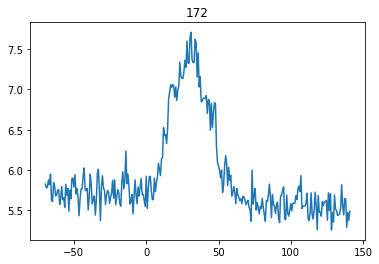

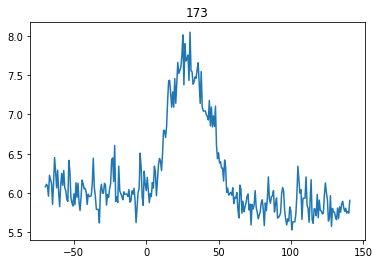

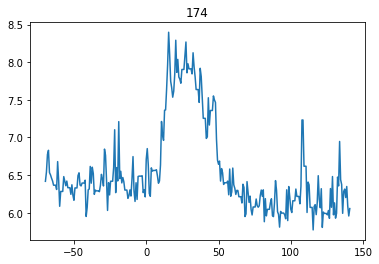

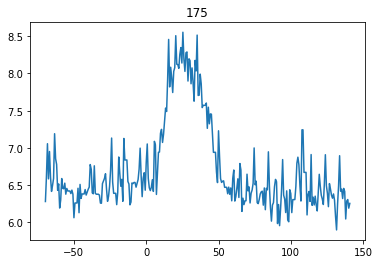

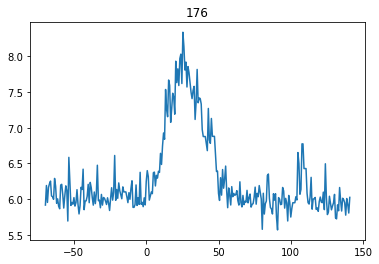

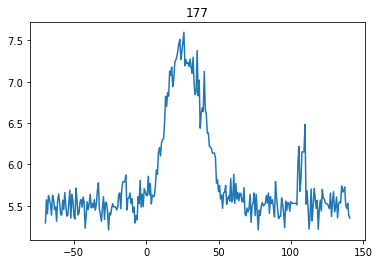

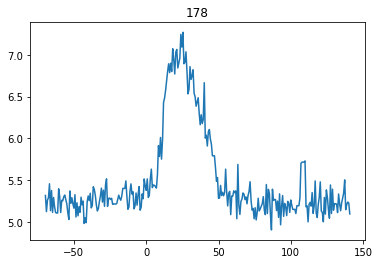

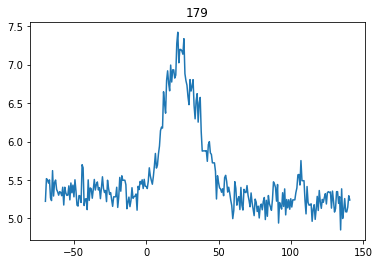

In [89]:
for i in np.arange(90,180):
    x=xv[i,:][200:500]
    y=yP_no_peak[i,:][200:500]
    plt.plot(x,y)
#     plt.axvline(width[i][0],color='r')
#     plt.axvline(width[i][1],color='r')
    plt.title(i)
    plt.show()


In [88]:
#delete the signal region and fit the spectrum with second degree polynomial.
def del_signal_and_fit(xv_vec,yP_vec,del_region=(-50,50)):
    x1del=del_region[0]
    x2del=del_region[1]
    xv=np.copy(xv_vec)
    yP_for_fit=np.copy(yP_vec)
    yP_original=np.copy(yP_vec)
    
    signal_region=(xv>x1del) &(xv<x2del)
    yP_for_fit[signal_region] = np.mean(yP_for_fit[~signal_region])
    
    z=np.polyfit(xv,yP_for_fit,2)
    p=np.poly1d(z)
#     print(yP)
    
#     for i in range(length):
#         xtmp=xv[i]
        
#         if (xtmp > x1del and xtmp < x2del):
#             XB[npoint]=xtmp
#             YB[npoint]=
#             npoint=npoint+1
#         else:
#             XB[npoint]=xtmp
#             YB[npoint]=yP[i]
#             npoint=npoint+1

#     plt.plot(xv,yP_for_fit)
#     plt.plot(xv,p(xv))
    fit=p(xv)
    YP=yP_original-fit
#     plt.plot(xv,YP)
    plt.show()
    return(YP)

In [72]:
subtracted_yP=np.empty([90,length])

for i in range(90):
    subtracted_yP[i,:]=del_signal_and_fit(xv[i,:],yP_no_peak[i,:],tuple(width[i]))

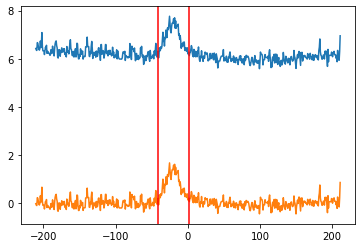

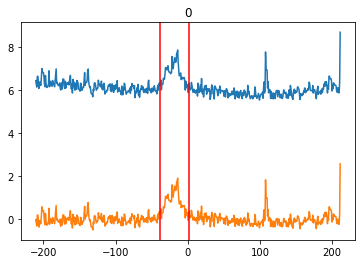

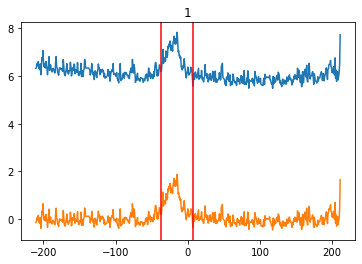

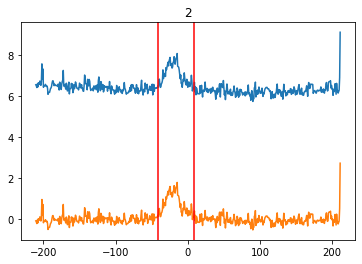

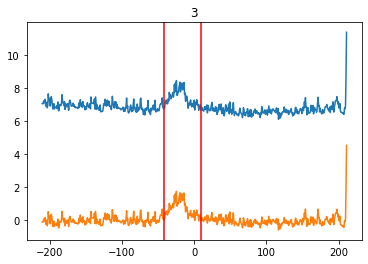

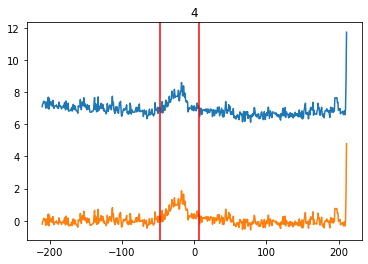

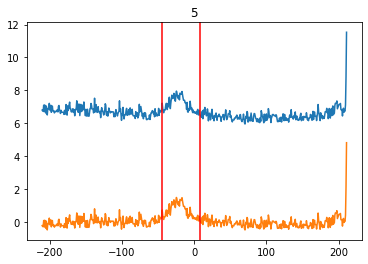

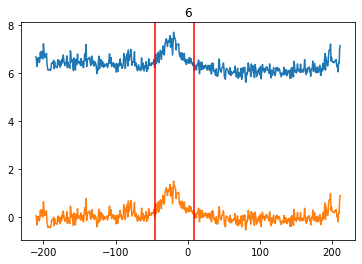

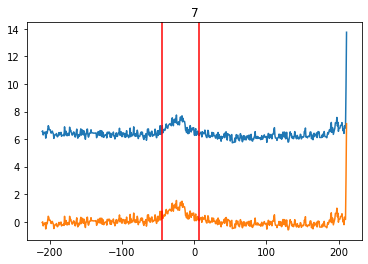

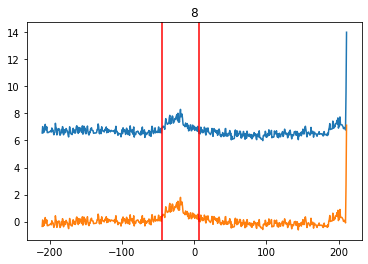

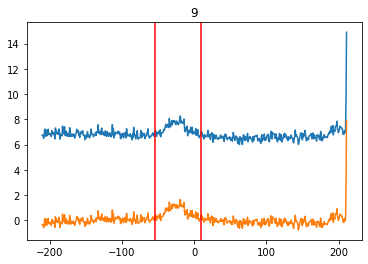

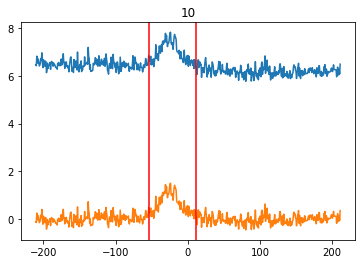

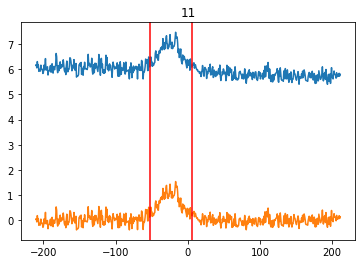

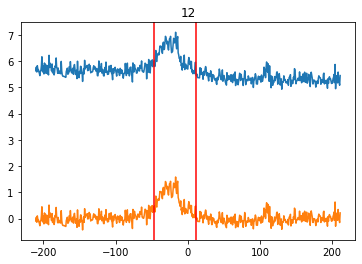

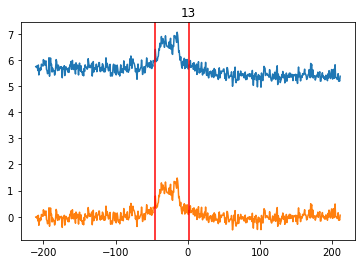

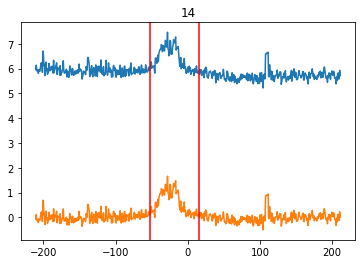

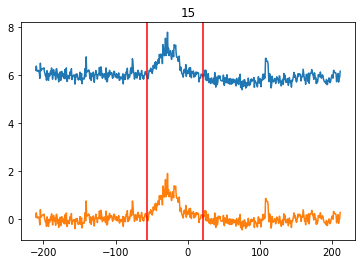

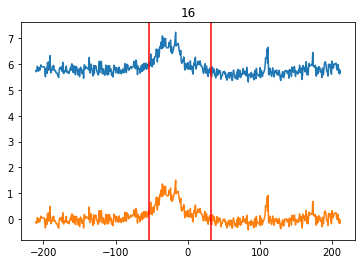

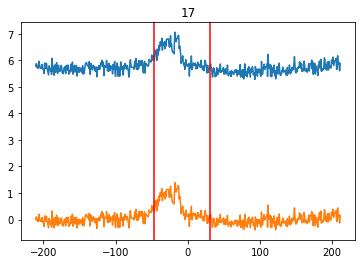

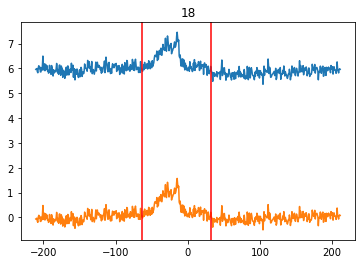

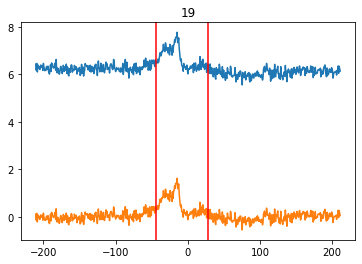

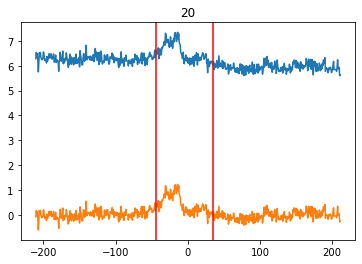

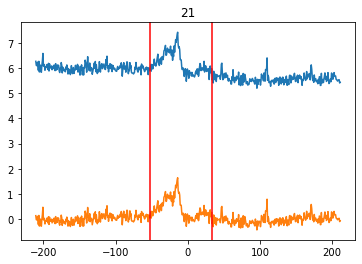

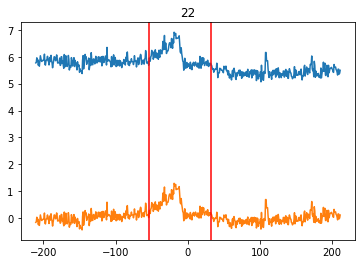

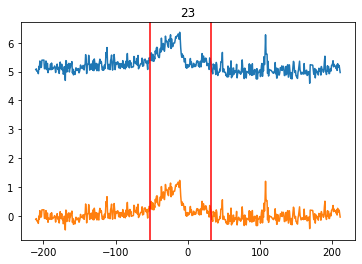

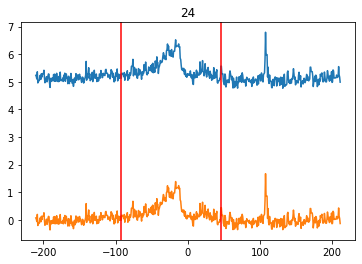

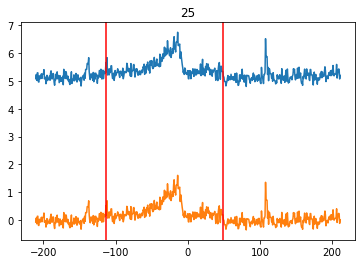

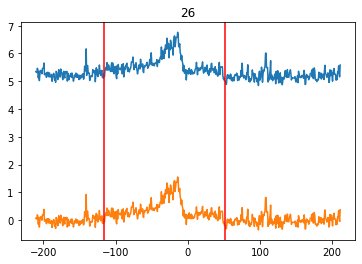

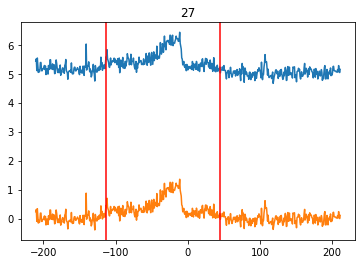

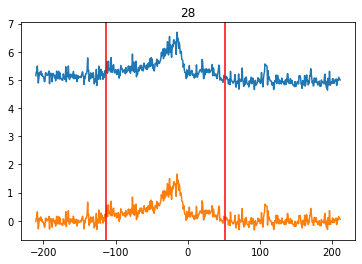

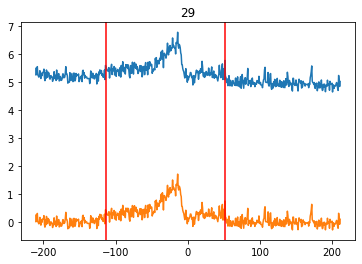

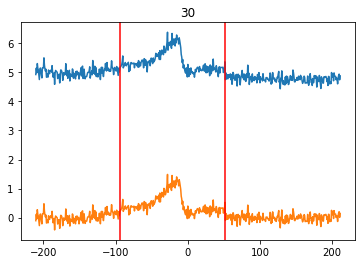

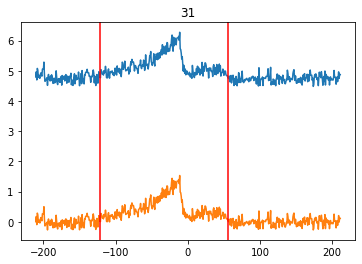

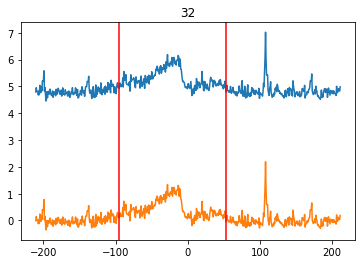

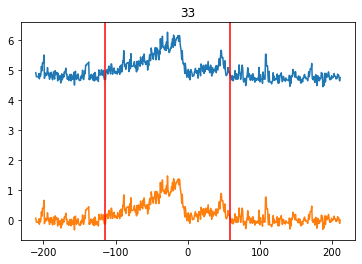

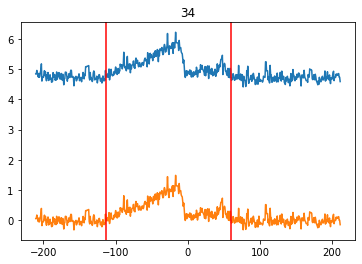

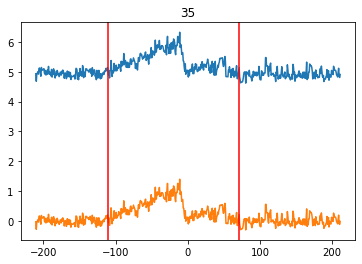

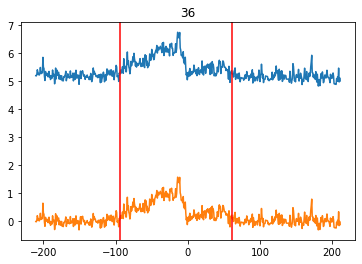

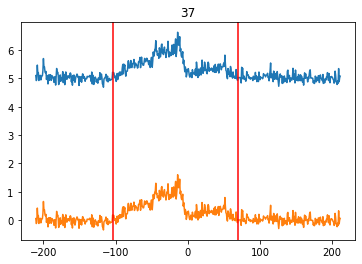

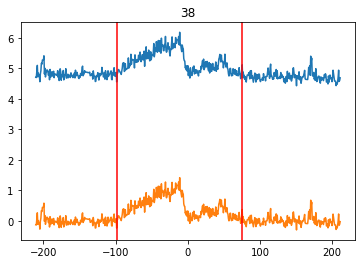

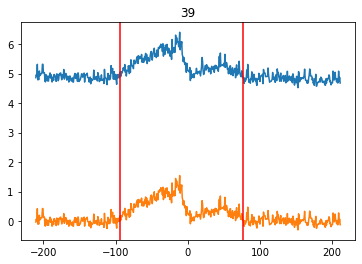

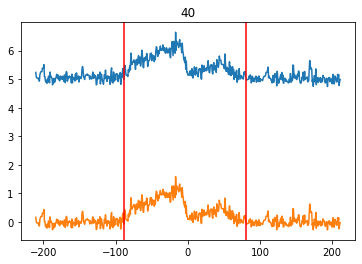

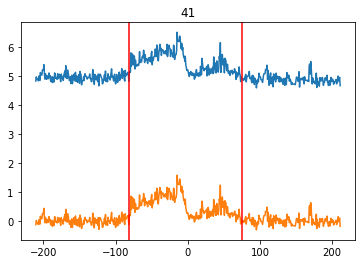

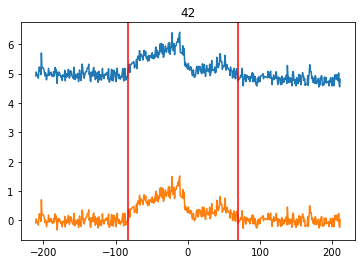

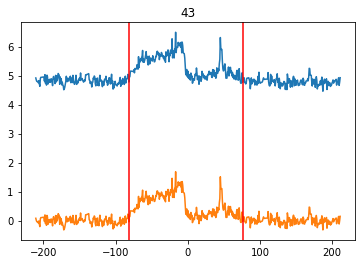

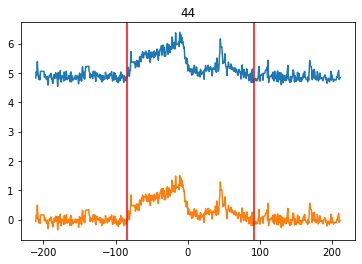

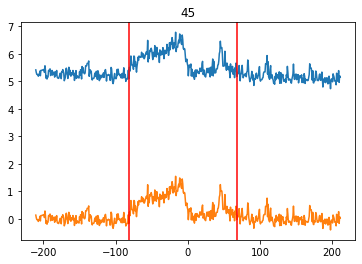

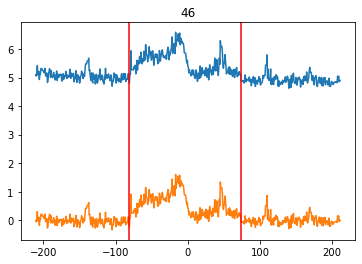

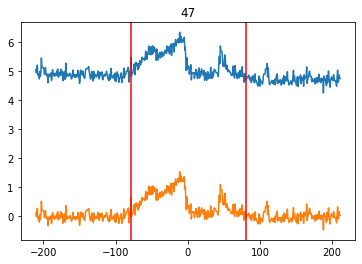

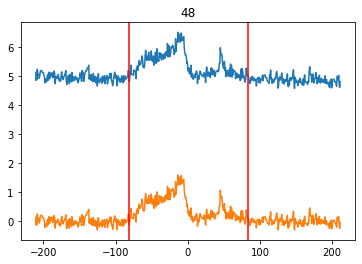

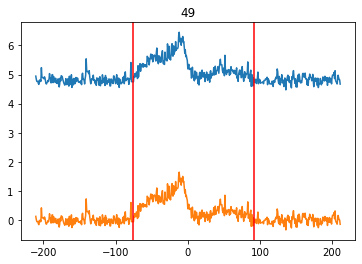

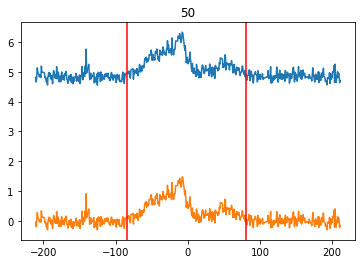

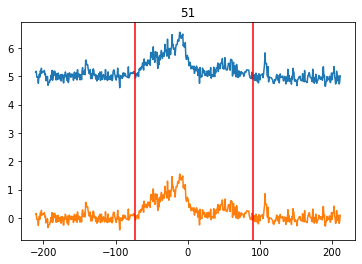

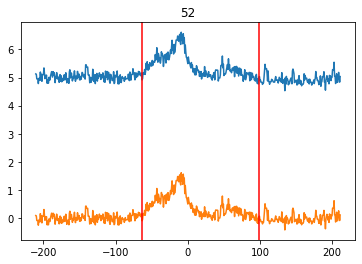

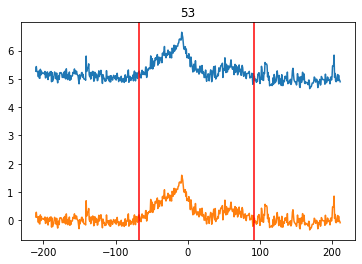

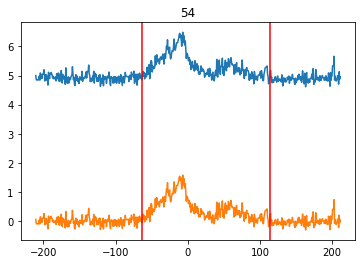

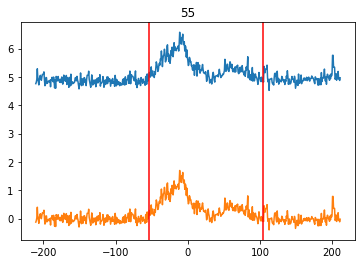

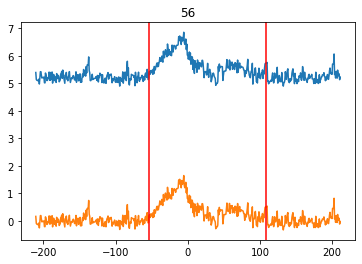

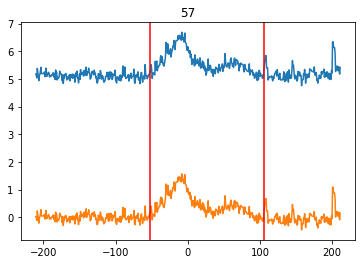

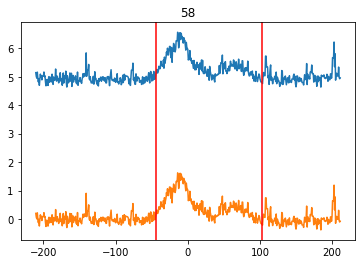

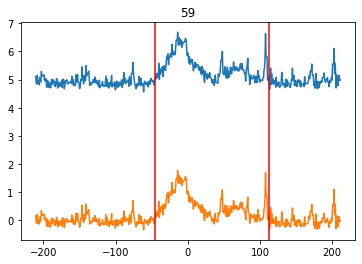

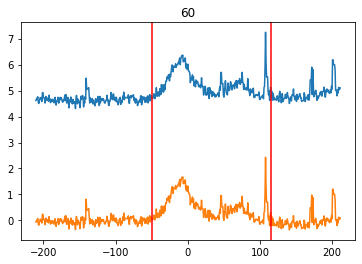

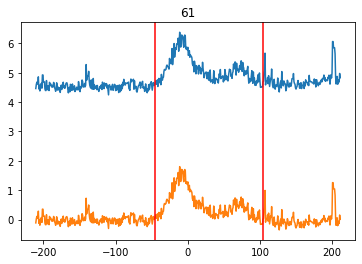

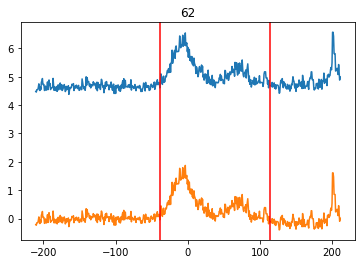

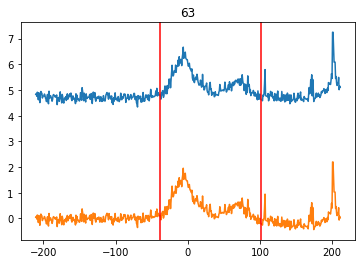

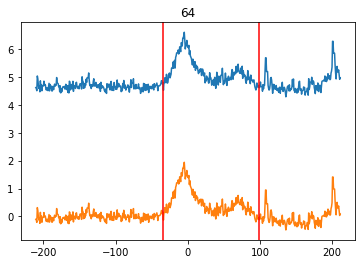

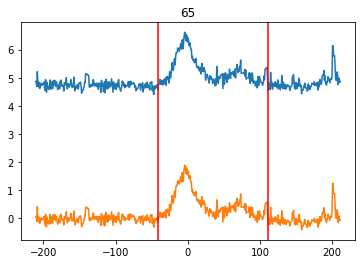

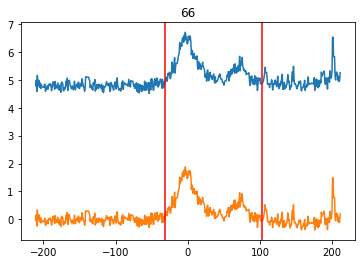

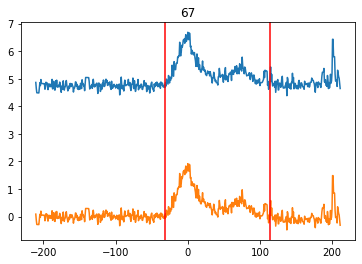

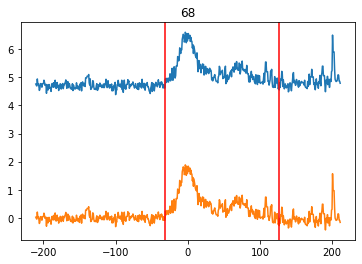

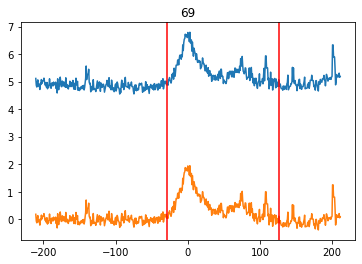

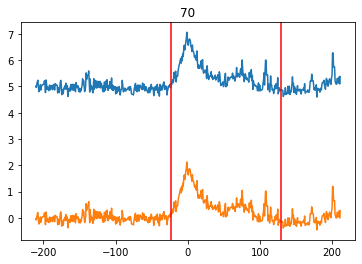

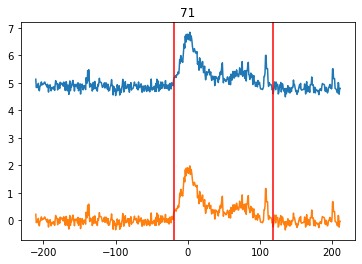

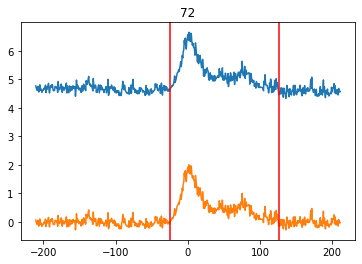

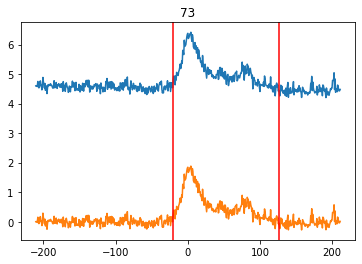

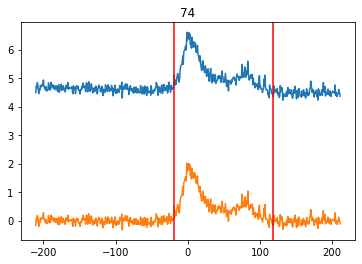

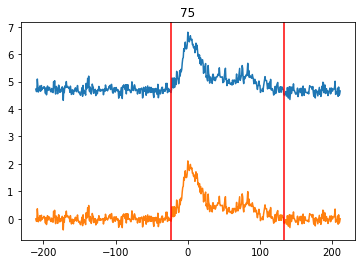

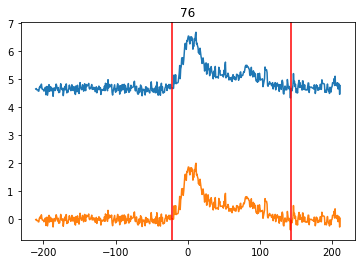

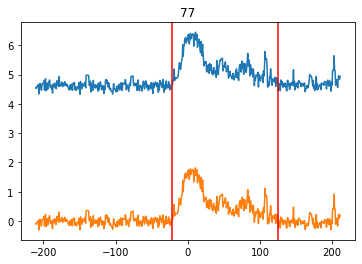

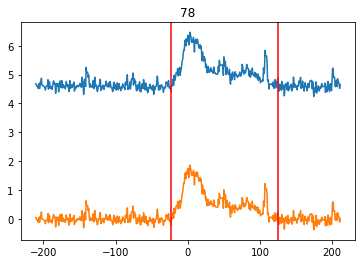

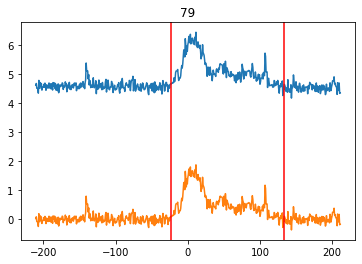

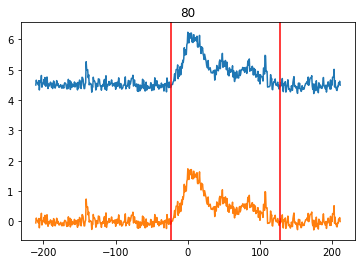

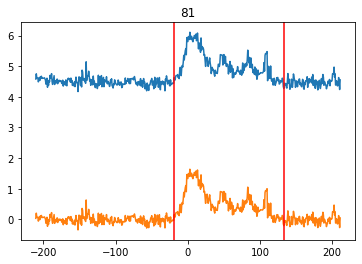

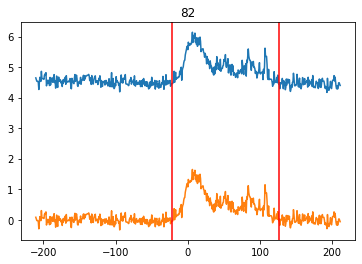

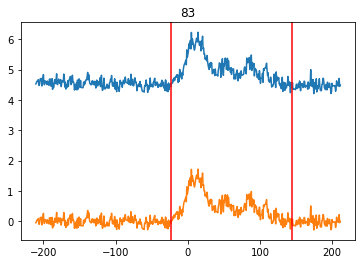

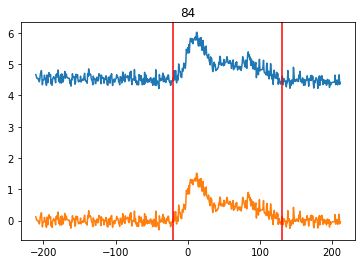

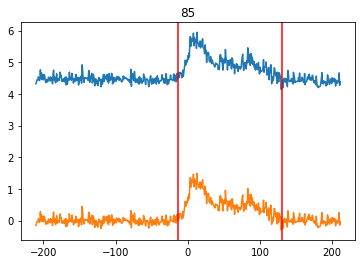

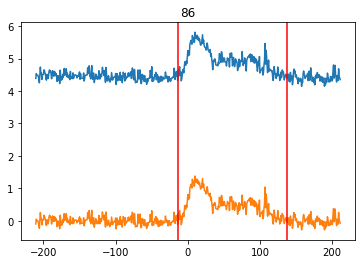

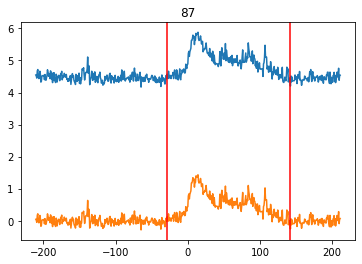

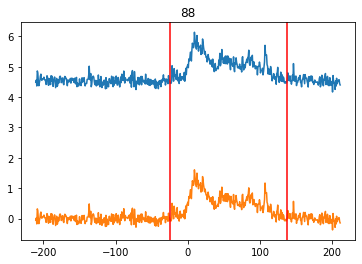

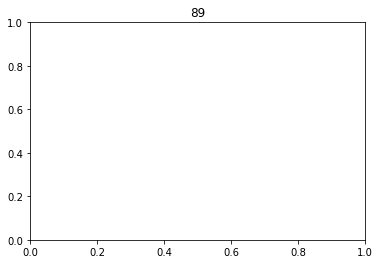

In [73]:
for i in range(90):
    x=xv[i,:]
    y=yP_no_peak[i,:]
    s_yP=subtracted_yP[i,:]
    plt.plot(x,y)
    plt.plot(x,s_yP)
#     plt.plot(x,YP)
    plt.axvline(width[i][0],color='r')
    plt.axvline(width[i][1],color='r')
    plt.show()
    plt.title(i)

In [49]:
tuple(width[1])

(-39, 2)